# Source Estimation


Some of the following is command-line code for Linux.

# (MNE-)Python preparation

In [14]:
# set paths
import sys

# figures within notebook
%matplotlib inline

# to keep copy of raw data
from copy import deepcopy

# for plotting
from matplotlib import pyplot as plt

# import numpy package
import numpy as np

# import MNE-Python tools
import mne

subjects_dir = '../data'

# check MNE-Python version
print('MNE-Python version: %s.' % mne.__version__)

MNE-Python version: 0.19.0.


# Look at MRI data and surface segmentations (Linux)

In Linux terminal window:
freeview
From data/CBU160881, load volume T1.mgz, then load surfaces as you see fit

Using surface: ../data/CBU160881/bem/inner_skull.surf
Using surface: ../data/CBU160881/bem/outer_skull.surf
Using surface: ../data/CBU160881/bem/outer_skin.surf


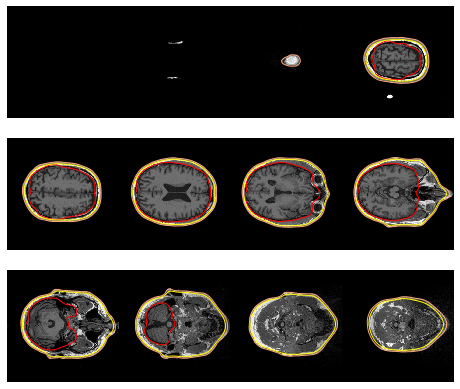

Using surface: ../data/CBU160881/bem/inner_skull.surf
Using surface: ../data/CBU160881/bem/outer_skull.surf
Using surface: ../data/CBU160881/bem/outer_skin.surf


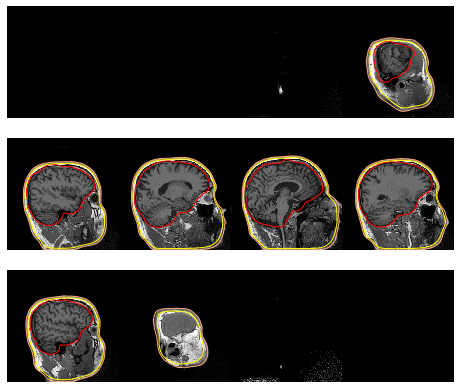

Using surface: ../data/CBU160881/bem/inner_skull.surf
Using surface: ../data/CBU160881/bem/outer_skull.surf
Using surface: ../data/CBU160881/bem/outer_skin.surf


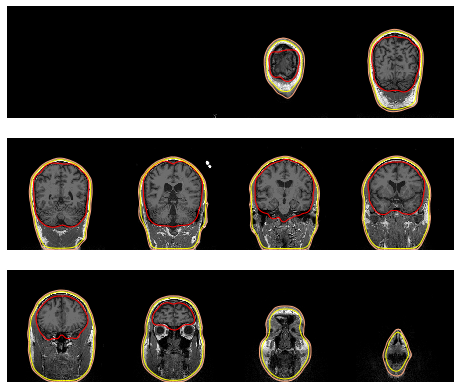

In [15]:
# Plot Boundary Element Model (BEM) surfaces
from mne.viz import plot_bem

fig = plot_bem(subject='CBU160881', subjects_dir=subjects_dir, orientation='axial')
fig = plot_bem(subject='CBU160881', subjects_dir=subjects_dir, orientation='sagittal')
fig = plot_bem(subject='CBU160881', subjects_dir=subjects_dir, orientation='coronal')

# Boundary Element Model (BEM)

In [17]:
# Note: Only one conductivity, i.e. only one compartment for MEG
model = mne.make_bem_model(subject='CBU160881', ico=4,
                                conductivity=(0.3,),
                                subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
mne.bem.write_bem_solution('../data/CBU160881-bem.fif', bem)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is   4.52 -13.06   5.75 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


# Prepare Source Space (cortex)

In [18]:
# The "oct" option determines the spatial sampling of the cortical surface
src = mne.setup_source_space('CBU160881', spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False)
mne.write_source_spaces('../data/CBU160881-src.fif', src, overwrite=True)

Setting up the source space with the following parameters:

SUBJECTS_DIR = ../data
Subject      = CBU160881
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading ../data/CBU160881/surf/lh.white...
Mapping lh CBU160881 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from ../data/CBU160881/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/148330 selected to source space (oct = 6)

Loading ../data/CBU160881/surf/rh.white...
Mapping rh CBU160881 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from ../data/CBU160881/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/154205 selected to source space (oct = 6)

You are now one step closer to computing the gain matrix
Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    

# Forward Solution ("leadfield")

In [19]:
# Read evoked data
evoked = mne.read_evokeds('../data/demo_audvis-ave.fif')

Reading ../data/demo_audvis-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     500.00 ms (1)
        0 CTF compensation matrices available
        nave = 353 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
    Found the data of interest:
        t =    -200.00 ...     500.00 ms (2)
        0 CTF compensation matrices available
        nave = 353 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied


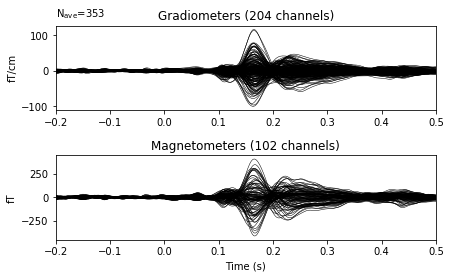

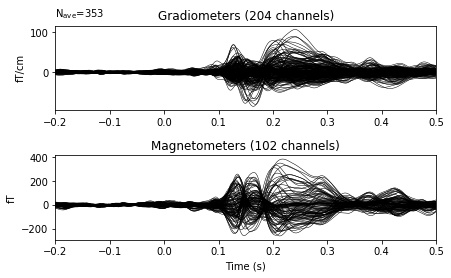

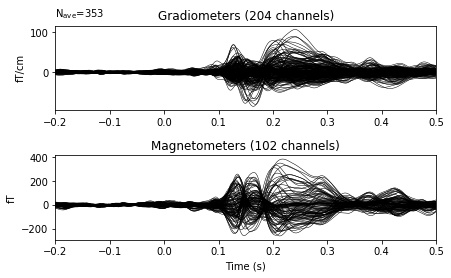

In [20]:
# quickly check whether evoked data look alright
# Auditory
evoked[0].plot()
# Visual
evoked[1].plot()

In [21]:
fwd = mne.make_forward_solution(evoked[0].info, trans='../data/demo_audvis_sss_raw-trans.fif', src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0)
mne.write_forward_solution(fname='../data/CBU160881-fwd.fif', fwd=fwd, overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=148330, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=154205, n_used=4098, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform : ../data/demo_audvis_sss_raw-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.995550  0.092706 -0.016888      -5.88 mm
    -0.076884  0.902740  0.423261      22.72 mm
     0.054484 -0.420079  0.905851      43.03 mm
     0.000000  0.000000  0.000000       1.00

Read 306 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     0.998124  0.050081 -0.035202      -5.50 mm
    -0.048917  0.998251  0.033191       2.50 mm
     0.036802 -0.031406  0.998829      49.41 mm

# Create Inverse Operator

In [22]:
# Read the forward solution ("leadfield")
fwd = mne.read_forward_solution('../data/CBU160881-fwd.fif')

Reading forward solution from ../data/CBU160881-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8194 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [23]:
# Read noise covariance matrix
noise_cov = mne.read_cov('../data/demo_audvis-cov.fif')

    306 x 306 full covariance (kind = 1) found.


In [24]:
# Regularise noise covariance matrix (can be done fancier, but takes more time)
noise_cov = mne.cov.regularize(noise_cov, evoked[0].info, mag=0.2, grad=0.2, rank='info')

Regularizing MEG channels jointly
Computing data rank from covariance with rank='info'
    MEG: rank 69 after 0 projectors applied to 306 channels
0 projection items activated
    MEG regularization : 0.2
Computing data rank from covariance with rank={'meg': 69}
    Setting small MEG eigenvalues to zero (without PCA)


In [25]:
# Create the inverse operator
invop = mne.minimum_norm.make_inverse_operator(evoked[0].info, fwd, noise_cov, loose=0.2, depth=None, rank='info')

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Computing data rank from covariance with rank='info'
    MEG: rank 69 after 0 projectors applied to 306 channels
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.08509
    scaling factor to adjust the trace = 8.24518e+19


In [12]:
# Write the inverse operator
mne.minimum_norm.write_inverse_operator(fname='../data/demo_audvis-inv.fif', inv=invop)

Write inverse operator decomposition in ../data/demo_audvis-inv.fif...
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
    Writing inverse operator info...
    Writing noise covariance matrix.
    Writing source covariance matrix.
    Writing orientation priors.
    [done]


In [26]:
stc = mne.minimum_norm.apply_inverse(evoked=evoked[0], inverse_operator=invop, lambda2=1./9., method='dSPM')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 353
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 69 (237 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "1"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  97.3% variance
    Combining the current components...
    dSPM...
[done]


Now we can look at the source estimates:

- Open a Linux terminal window
- Type "ipython" to open an ipython window
- Type "run plot_source_estimate.py" in ipython window
- Edit plot_source_estimate.py and play around with it.
